You must run this notebook on a GPU. A T4 is sufficient. It's free on [Google
Colab](https://stackoverflow.com/questions/62596466/how-can-i-run-notebooks-of-a-github-project-in-google-colab/67344477#67344477).

**Description**: for a [GPTQd Mistral
7B](https://huggingface.co/TheBloke/Mistral-7B-OpenOrca-GPTQ) and the [Banking
77](https://huggingface.co/datasets/PolyAI/banking77) classification task, this notebook
demonstrates that CAPPr gets you +4% absolute accuracy compared to text generation. This
is only a statistical comparison though. Computationally, CAPPr is currently much
slower. On a machine w/ more GPU RAM, it'd look fast b/c we can batch. I'll improve this
in the [near
future](https://github.com/users/kddubey/projects/1/views/1?pane=issue&itemId=42888520).

This notebook also demonstrates using the HF
[`cache`](https://cappr.readthedocs.io/en/latest/cappr.huggingface.classify_no_batch.html#cappr.huggingface.classify_no_batch.cache)
context manager, and suggests that CAPPr's probabilities are reasonably calibrated.

**Estimated run time**: ~30 min.

In [1]:
# check correct CUDA version
import torch

_cuda_version = torch.version.cuda
_msg = (
    "Change the pip install auto-gptq command to the one for "
    f"{_cuda_version} based on the list here: "
    "https://github.com/PanQiWei/AutoGPTQ#quick-installation"
)

assert _cuda_version == "11.8", _msg

In [ ]:
!python -m pip install "cappr[demos] @ git+https://github.com/kddubey/cappr.git" \
auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/ \
optimum

In [3]:
from __future__ import annotations
from typing import Sequence

import datasets
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.calibration import calibration_curve
from tqdm.auto import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

from cappr import huggingface as hf

# Load data

In [4]:
df = pd.DataFrame(datasets.load_dataset("PolyAI/banking77", split="train"))

Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [5]:
original_class_names = ["Refund_not_showing_up", "activate_my_card", "age_limit", "apple_pay_or_google_pay", "atm_support", "automatic_top_up", "balance_not_updated_after_bank_transfer", "balance_not_updated_after_cheque_or_cash_deposit", "beneficiary_not_allowed", "cancel_transfer", "card_about_to_expire", "card_acceptance", "card_arrival", "card_delivery_estimate", "card_linking", "card_not_working", "card_payment_fee_charged", "card_payment_not_recognised", "card_payment_wrong_exchange_rate", "card_swallowed", "cash_withdrawal_charge", "cash_withdrawal_not_recognised", "change_pin", "compromised_card", "contactless_not_working", "country_support", "declined_card_payment", "declined_cash_withdrawal", "declined_transfer", "direct_debit_payment_not_recognised", "disposable_card_limits", "edit_personal_details", "exchange_charge", "exchange_rate", "exchange_via_app", "extra_charge_on_statement", "failed_transfer", "fiat_currency_support", "get_disposable_virtual_card", "get_physical_card", "getting_spare_card", "getting_virtual_card", "lost_or_stolen_card", "lost_or_stolen_phone", "order_physical_card", "passcode_forgotten", "pending_card_payment", "pending_cash_withdrawal", "pending_top_up", "pending_transfer", "pin_blocked", "receiving_money", "request_refund", "reverted_card_payment?", "supported_cards_and_currencies", "terminate_account", "top_up_by_bank_transfer_charge", "top_up_by_card_charge", "top_up_by_cash_or_cheque", "top_up_failed", "top_up_limits", "top_up_reverted", "topping_up_by_card", "transaction_charged_twice", "transfer_fee_charged", "transfer_into_account", "transfer_not_received_by_recipient", "transfer_timing", "unable_to_verify_identity", "verify_my_identity", "verify_source_of_funds", "verify_top_up", "virtual_card_not_working", "visa_or_mastercard", "why_verify_identity", "wrong_amount_of_cash_received", "wrong_exchange_rate_for_cash_withdrawal"]
original_class_names = sorted([class_name.lower() for class_name in original_class_names])

In [6]:
class_names = [
    " ".join(class_name.split("_")).capitalize() for class_name in original_class_names
]
class_names_str = "\n".join(sorted(class_names))

In [7]:
df["class_name"] = [class_names[label_idx] for label_idx in df["label"]]

In [8]:
len(df)

10003

We don't need this much data. Sample down

In [9]:
df_tr_mini = df.sample(n=200, random_state=123).reset_index(drop=True)

What's majority accuracy?

In [10]:
df_tr_mini["label"].value_counts(normalize=True).max()

0.03

# Load model

In [ ]:
model_name = "TheBloke/Mistral-7B-OpenOrca-GPTQ"
model = AutoModelForCausalLM.from_pretrained(
    model_name, device_map="auto", trust_remote_code=False, revision="main"
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [12]:
# warm up model
_ = model(**tokenizer(["warm up"], return_tensors="pt").to(model.device))

# Text generation

In [13]:
chat_template = """
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start|>assistant
""".lstrip("\n")

Prompt stolen from: https://github.com/refuel-ai/autolabel/blob/main/examples/banking/config_banking.json

In [14]:
def prompt_text_gen(text: str):
    system_prompt = (
        "You are an expert at understanding bank customers support complaints and "
        "queries.\n"
        "Your job is to correctly categorize an inputted customer query or complaint "
        "into one of the following categories.\n"
        "Categories:\n"
        f"{class_names_str}\n\n"
        "You will answer with just the the correct category and nothing else."
    )
    user_message = f"Categorize the following query: {text}"
    return chat_template.format(
        system_message=system_prompt, prompt=user_message
    )

df_tr_mini["prompt_text_gen"] = [prompt_text_gen(query) for query in df_tr_mini["text"]]
print(df_tr_mini["prompt_text_gen"].iloc[0])

<|im_start|>system
You are an expert at understanding bank customers support complaints and queries.
Your job is to correctly categorize an inputted customer query or complaint into one of the following categories.
Categories:
Activate my card
Age limit
Apple pay or google pay
Atm support
Automatic top up
Balance not updated after bank transfer
Balance not updated after cheque or cash deposit
Beneficiary not allowed
Cancel transfer
Card about to expire
Card acceptance
Card arrival
Card delivery estimate
Card linking
Card not working
Card payment fee charged
Card payment not recognised
Card payment wrong exchange rate
Card swallowed
Cash withdrawal charge
Cash withdrawal not recognised
Change pin
Compromised card
Contactless not working
Country support
Declined card payment
Declined cash withdrawal
Declined transfer
Direct debit payment not recognised
Disposable card limits
Edit personal details
Exchange charge
Exchange rate
Exchange via app
Extra charge on statement
Failed transfer
Fia

In [15]:
generator = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
)

generation_config = GenerationConfig(
    max_new_tokens=20,
    num_return_sequences=1,
    eos_token_id=tokenizer.eos_token_id,
    batch_size=1,
)

In [ ]:
completions = []
for prompt in tqdm(df_tr_mini["prompt_text_gen"], total=len(df_tr_mini), desc="Sampling"):
    sequences = generator(
        prompt,
        generation_config=generation_config,
        pad_token_id=generator.tokenizer.eos_token_id,  # suppress "Setting ..."
    )
    completions.append(sequences[0]["generated_text"])

Let's see if the model generated categories like we asked.

In [17]:
pd.Series(completions).sample(10).tolist()

[' Transfer failed',
 ' Transfer into account',
 ' Card delivery estimate',
 ' Supported cards and currencies',
 ' Refund not showing up',
 ' Card not working',
 ' Cash withdrawal charge',
 ' Wrong amount of cash received',
 ' Cash withdrawal not recognised',
 ' Cancel transfer']

They look good

In [18]:
def process_completion(completion: str, class_names: Sequence[str], default=-1) -> int:
    for i, name in enumerate(class_names):
        if name.lower() in completion.lower():
            return i
    return default

In [19]:
preds_text_gen = pd.Series([
    process_completion(completion, class_names)
    for completion in completions
])

How many of the completions could be mapped to a label?

In [20]:
(preds_text_gen != -1).mean()

0.87

That's bad. More than 1 in 10 are not a valid choice. What do invalid completions look like?

In [21]:
pd.Series(completions)[preds_text_gen == -1].sample(10).tolist()

[' Verify identity',
 ' Reverted card payment',
 ' Card security measures',
 ' Change address',
 ' Top up not working',
 ' Top up by card',
 ' Top up by card',
 ' Adding other people to your account, so they can top up',
 ' Top up by card',
 ' Virtual card']

I don't think improving `process_completion` is the way to go—that seems too tricky. For
a fairer comparison, assume these get always mapped to one of the choices. It's more
fair to apply a string distance match or a similarity search from a small similarity
model. Those solutions are kinda annoying and complicated. For now I'm just gonna map it
to the most common class. That's more optimistic than mapping them uniformly-at-random.

In [22]:
most_common_label = (
    df_tr_mini["label"].value_counts(normalize=True, ascending=False).index[0]
)
most_common_label

70

In [23]:
preds_text_gen_imputed = preds_text_gen.copy()
preds_text_gen_imputed[preds_text_gen_imputed == -1] = most_common_label

In [24]:
(df_tr_mini["label"] == preds_text_gen_imputed).mean()

0.535

I'm also curious what accuracy is given the completion is valid:

In [25]:
_mask_valid = preds_text_gen != -1
(df_tr_mini.loc[_mask_valid, "label"] == preds_text_gen[_mask_valid]).mean()

0.5977011494252874

# CAPPr

Important note: CAPPr is currently very slow when the prompt is too long for completions
to be processed in parallel. We'll have to process completions 1-by-1 to stay under 15
GB RAM. See [this
section](https://cappr.readthedocs.io/en/latest/computational_performance.html#weaknesses)
of the documentation. I plan on improving this soon.

Let's compare statistical performance, keeping the prompt the same as the one for text
generation.

We'll cache a shared part of the whole prompt, whose format is
`chat_template_shared_instructions`.

In [27]:
chat_template_shared_instructions = """
<|im_start|>system
{system_message}<|im_end|>
<|im_start|>user
{user_prompt}
""".strip("\n")

chat_template_prompt = """
{prompt}<|im_end|>
<|im_start|>assistant
""".lstrip("\n")

In [28]:
class_names_str = "\n".join(sorted(class_names))
system_message = (
    "You are an expert at understanding bank customers support complaints and "
    "queries.\n"
    "Your job is to correctly categorize an inputted customer query or complaint "
    "into one of the following categories.\n"
    "Categories:\n"
    f"{class_names_str}\n\n"
    "You will answer with just the the correct category and nothing else."
)
user_prompt = "Categorize the following query:"
prompt_prefix = chat_template_shared_instructions.format(
    system_message=system_message,
    user_prompt=user_prompt,
)

df_tr_mini["prompt_suffix"] = [
    chat_template_prompt.format(prompt=text) for text in df_tr_mini["text"]
]

In [29]:
# here's what the model will see
print(prompt_prefix + " " + df_tr_mini["prompt_suffix"].iloc[0])

<|im_start|>system
You are an expert at understanding bank customers support complaints and queries.
Your job is to correctly categorize an inputted customer query or complaint into one of the following categories.
Categories:
Activate my card
Age limit
Apple pay or google pay
Atm support
Automatic top up
Balance not updated after bank transfer
Balance not updated after cheque or cash deposit
Beneficiary not allowed
Cancel transfer
Card about to expire
Card acceptance
Card arrival
Card delivery estimate
Card linking
Card not working
Card payment fee charged
Card payment not recognised
Card payment wrong exchange rate
Card swallowed
Cash withdrawal charge
Cash withdrawal not recognised
Change pin
Compromised card
Contactless not working
Country support
Declined card payment
Declined cash withdrawal
Declined transfer
Direct debit payment not recognised
Disposable card limits
Edit personal details
Exchange charge
Exchange rate
Exchange via app
Extra charge on statement
Failed transfer
Fia

In [30]:
with hf.classify_no_batch.cache((model, tokenizer), prompt_prefix) as cached:
    pred_probs = hf.classify_no_batch.predict_proba(
        prompts=df_tr_mini["prompt_suffix"],
        completions=class_names,
        model_and_tokenizer=cached,
    )

conditional log-probs:   0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
(df_tr_mini["label"] == pred_probs.argmax(axis=1)).mean()

0.575

# CAPPr - small prompt

How well can LMs classify without having classes in their context? If they can do so just fine, we'd save model
context and GPU memory requirements. Let's see how well a summarizaton-style prompt
works.

In [32]:
def prompt(text: str) -> str:
    system_message = (
        "Summarize a banking customer service query in a few words."
    )
    prompt = f'Query: {text}\nSummary:'
    return chat_template.format(
        system_message=system_message, prompt=prompt
    )

In [34]:
df_tr_mini["prompt"] = [prompt(text) for text in df_tr_mini["text"]]
print(df_tr_mini["prompt"].iloc[0])

<|im_start|>system
Summarize a banking customer service query in a few words.<|im_end|>
<|im_start|>user
Query: I'm worried my card might be lost in the mail? How long does it usually take to arrive?
Summary:<|im_end|>
<|im_start|>assistant



In [35]:
print(df_tr_mini["class_name"].iloc[0])

Card delivery estimate


In [36]:
pred_probs_small_prompt = hf.classify.predict_proba(
    prompts=df_tr_mini["prompt"],
    completions=class_names,
    model_and_tokenizer=(model, tokenizer),
    batch_size=2,
)

conditional log-probs:   0%|          | 0/200 [00:00<?, ?it/s]

In [37]:
(df_tr_mini["label"] == pred_probs_small_prompt.argmax(axis=1)).mean()

0.365

That's a 20% drop in accuracy, yikes. We can't get away w/ this prompting style for this
task.

## Calibration

While we're here, check out calibration.

In [38]:
def plot_calibration_curve(y, pred_probs, n_bins=5, title=""):
    # gather statistics
    prob_true, prob_pred = calibration_curve(y, pred_probs, n_bins=n_bins)
    bins = np.linspace(0, 1, n_bins + 1)
    bin_inds = np.digitize(pred_probs, bins) - 1
    bin_sizes = np.bincount(bin_inds)
    y_std_err = np.sqrt(prob_true * (1 - prob_true) / bin_sizes)

    # plot curve
    plt.errorbar(
        prob_pred,
        prob_true,
        yerr=2 * y_std_err,
        label="Model w/ 95% CI",
        capsize=5,
        marker="o",
        linestyle="dashed",
    )
    plt.plot([0, 1], [0, 1], label="Perfect calibration")
    plt.legend()
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xlabel("Predicted probability")
    plt.ylabel("Observed fraction correct")
    plt.title(title)

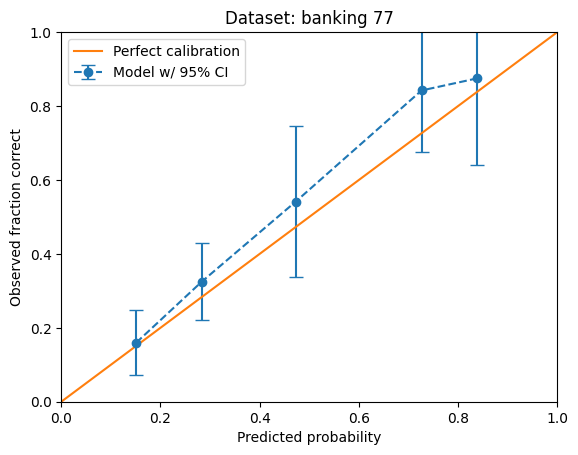

In [41]:
plot_calibration_curve(
    df_tr_mini["label"] == pred_probs_small_prompt.argmax(axis=1),
    pred_probs_small_prompt.max(axis=1),
    n_bins=5,
    title="Dataset: banking 77",
)

That's pretty good considering there are 77 classes. One application of calibrated
probabilities is that they make auto-approval systems easy to configure: you can
immediately guess-timate a threshold for the smallest probabilty that meets some
requirement on correctness. I'll flesh out auto-approval in a different notebook.

Let's see how calibrated the bigger, more discriminative prompt is.

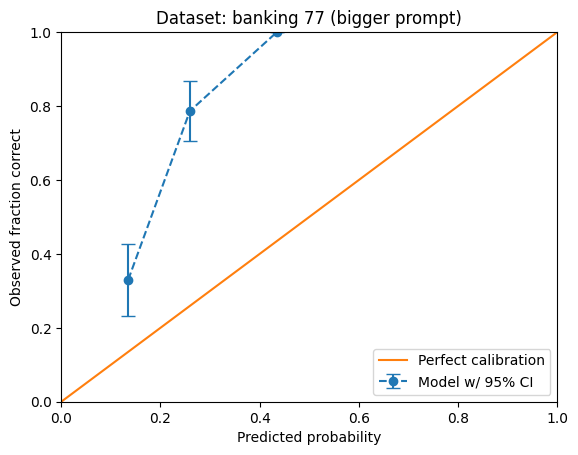

In [45]:
plot_calibration_curve(
    df_tr_mini["label"] == pred_probs.argmax(axis=1),
    pred_probs.max(axis=1),
    n_bins=5,
    title="Dataset: banking 77 (bigger prompt)",
)

Weird! It's not as calibrated. Maybe it's still better for auto-approval applications. I'll take a look later.